In [1]:
from utils import *
from sklearn.preprocessing import MinMaxScaler

In [2]:
check_tensorflow_gpu()

... Checking Tensorflow Version ...
Tensorflow built with CUDA? True
TF: 2.10.0 | CUDA: 64_112 | cuDNN: 64_8
# GPU available: 1 (NVIDIA GeForce RTX 3080)


In [22]:
logperm, perm, poro, timesteps, bhp, pressure, saturation, well_locs, well_locs_mask = load_data()

Log-Perm: (32, 32)
Permeability: (32, 32, 3) | Porosity: (32, 32)
Pressure: (100, 32, 32, 60) | Saturation: (100, 32, 32, 60)
Timesteps: (60, 1) | BHP: (100, 60)
Well Locations: (100, 2) | Well Locations MASK: (100, 32, 32)


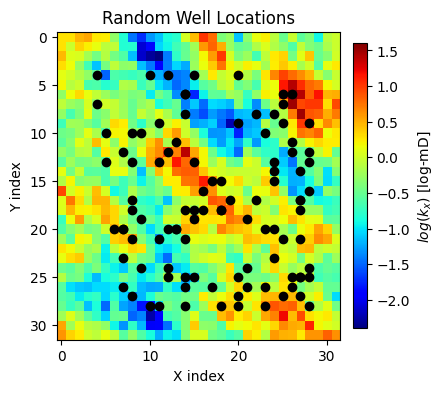

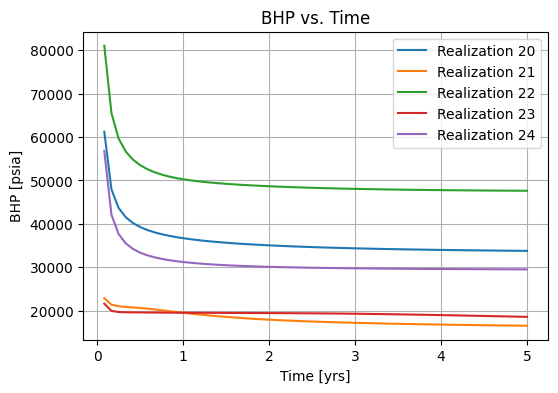

In [4]:
plot_well_locs(well_locs, logperm)
plot_bhps(bhp, timesteps, range(20,25))

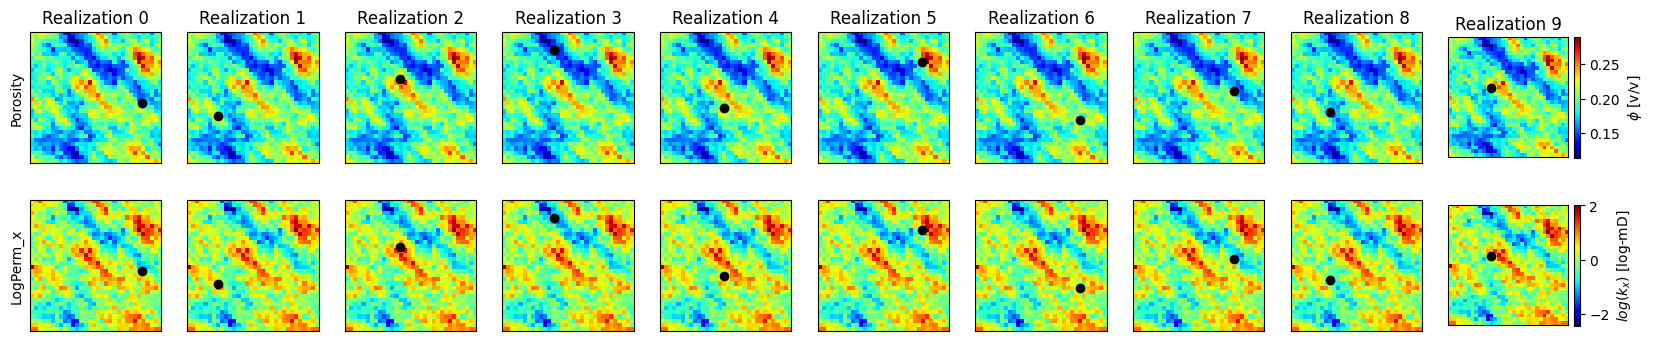

In [5]:
plot_static(poro, perm, well_locs, 10, figsize=(20,4))

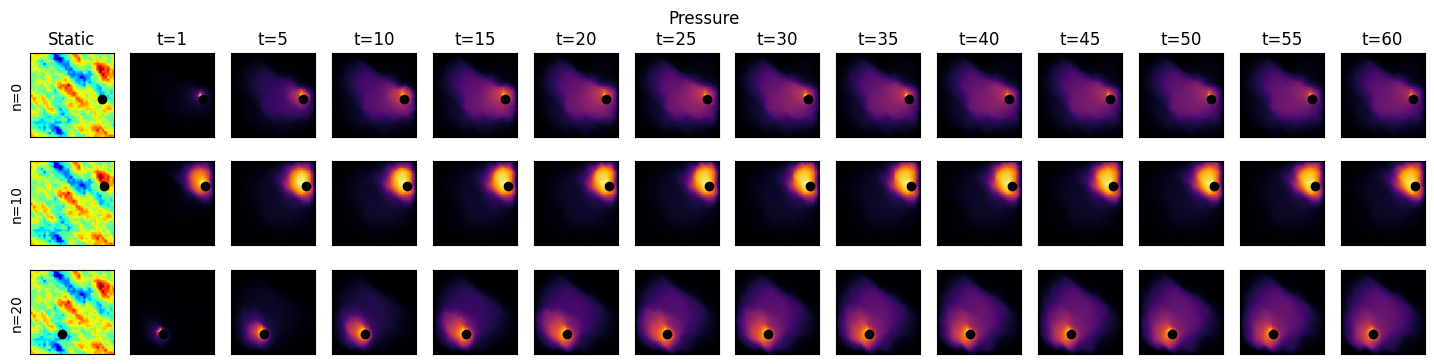

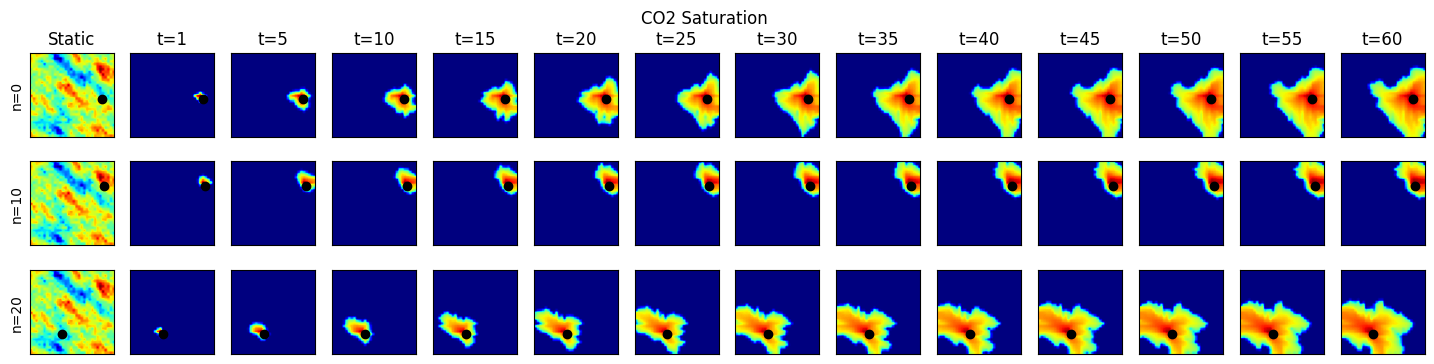

In [6]:
plot_dynamic(pressure, logperm, well_locs, nrows=3, multiplier=10, cmap='inferno', dtitle='Pressure')
plot_dynamic(saturation, logperm, well_locs, nrows=3, multiplier=10, cmap='jet', dtitle='CO2 Saturation')

(6000, 32, 32, 1)


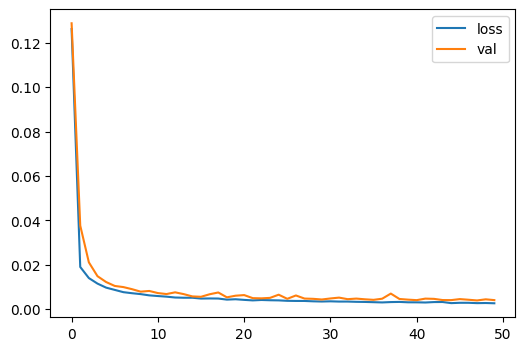

188/188 [==============================] - 1s 3ms/step


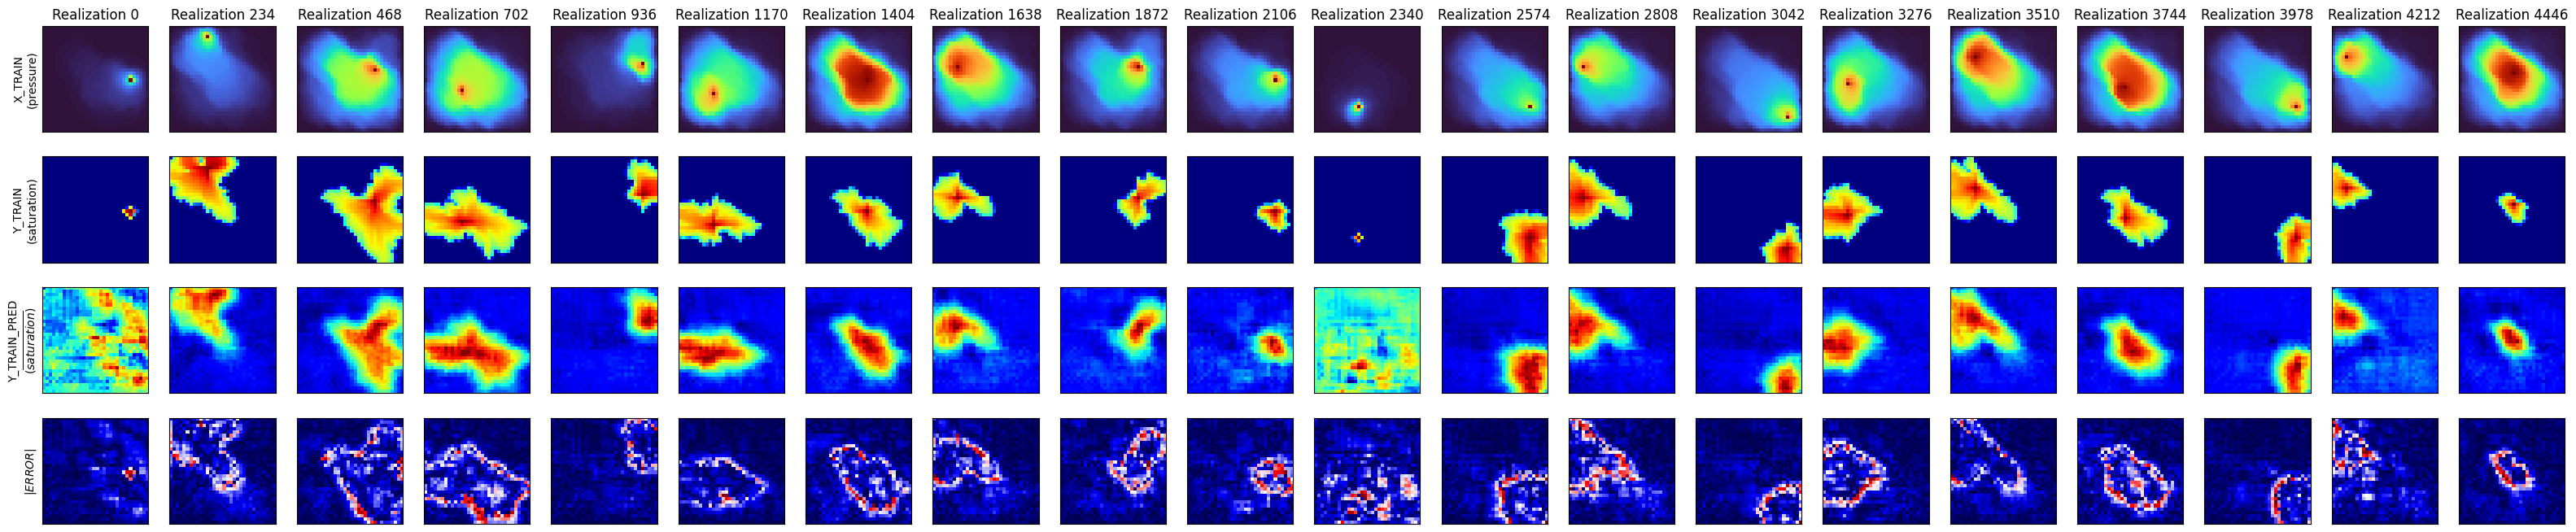

In [7]:
import tensorflow as tf
import keras
from keras import Model
from keras.layers import Input
from keras.layers import Conv2D, BatchNormalization, LeakyReLU
from keras.layers import UpSampling2D, MaxPooling2D
from keras.optimizers import Adam

x_train = np.expand_dims(np.moveaxis(pressure, -1, 1).reshape(6000,32,32), -1)
y_train = np.expand_dims(np.moveaxis(saturation, -1, 1).reshape(6000,32,32), -1)
print(x_train.shape)

def make_cnn():
    keras.backend.clear_session()
    inp = Input(shape=(32, 32, 1))
    
    x = Conv2D(filters=16, kernel_size=3, padding='same', activation=LeakyReLU())(inp)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(filters=32, kernel_size=3, padding='same', activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(filters=64, kernel_size=3, padding='same', activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(filters=32, kernel_size=3, padding='same', activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = UpSampling2D()(x)

    x = Conv2D(filters=16, kernel_size=3, padding='same', activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = UpSampling2D()(x)
    
    x = Conv2D(filters=16, kernel_size=3, padding='same', activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = UpSampling2D()(x)
    
    out = Conv2D(filters=1, kernel_size=3, padding='same')(x)
    return Model(inp, out)

proxy = make_cnn()
#proxy.summary()

proxy.compile(optimizer='adam', loss='mse', metrics=['mse'])

fit = proxy.fit(x_train, y_train,
                epochs = 50,
                batch_size = 60,
                validation_split = 0.2,
                verbose = 0)

plt.figure(figsize=(6,4))
plt.plot(fit.history['loss'], label='loss')
plt.plot(fit.history['val_loss'], label='val')
plt.legend(); plt.show()

y_train_pred = proxy.predict(x_train)

numcols = 20
fig, axs = plt.subplots(4, numcols, figsize=(40,8))
k = 0
for j in range(numcols):
    axs[0,j].imshow(x_train[k], cmap='turbo'); axs[0,0].set(ylabel='X_TRAIN\n(pressure)')
    axs[1,j].imshow(y_train[k], cmap='jet'); axs[1,0].set(ylabel='Y_TRAIN\n(saturation)')
    axs[2,j].imshow(y_train_pred[k], cmap='jet'); axs[2,0].set(ylabel='Y_TRAIN_PRED\n($\overline{saturation}$)')
    axs[3,j].imshow(np.abs(y_train[k] - y_train_pred[k]), cmap='seismic'); axs[3,0].set(ylabel='$|ERROR|$')
    axs[0,j].set(title='Realization {}'.format(k))
    for i in range(4):
        axs[i,j].set(xticks=[], yticks=[])
    k += 234
plt.show()

***
# END

In [93]:
times_mask = np.zeros((100,32,32,60))
for i in range(100):
    for j in range(60):
        times_mask[i,:,:,j] = np.ones((32,32)) * j

In [178]:
p = np.repeat(np.expand_dims(np.expand_dims(np.repeat(np.expand_dims(MinMaxScaler().fit_transform(poro.reshape(-1,1)).reshape(32,32), 0),100,0),-1),-1), 60, -2)
w = np.repeat(np.expand_dims(np.expand_dims(np.flip(np.rot90(well_locs_mask, 1, axes=(-2,-1)),1),-1),-1), 60, -2)
t = np.expand_dims(times_mask/59, -1)
print('p={} | w={} | t={}'.format(p.shape, w.shape, t.shape))

pres = np.expand_dims(np.moveaxis(MinMaxScaler().fit_transform(pressure.reshape(100,-1)).reshape(100,32,32,60), -1,1).reshape(100*60,32,32),-1)
sat  = np.expand_dims(np.moveaxis(MinMaxScaler().fit_transform(saturation.reshape(100,-1)).reshape(100,32,32,60),-1,1).reshape(100*60,32,32),-1)
print('pres={}  | sat={}'.format(pres.shape, sat.shape))

x_data = np.moveaxis(np.concatenate([p,w,t], -1), -2, 1).reshape(100*60,32,32,3)
y_data = np.concatenate([pres,sat], -1)
print('X={} | y={}'.format(x_data.shape, y_data.shape))

p=(100, 32, 32, 60, 1) | w=(100, 32, 32, 60, 1) | t=(100, 32, 32, 60, 1)
pres=(6000, 32, 32, 1)  | sat=(6000, 32, 32, 1)
X=(6000, 32, 32, 3) | y=(6000, 32, 32, 2)


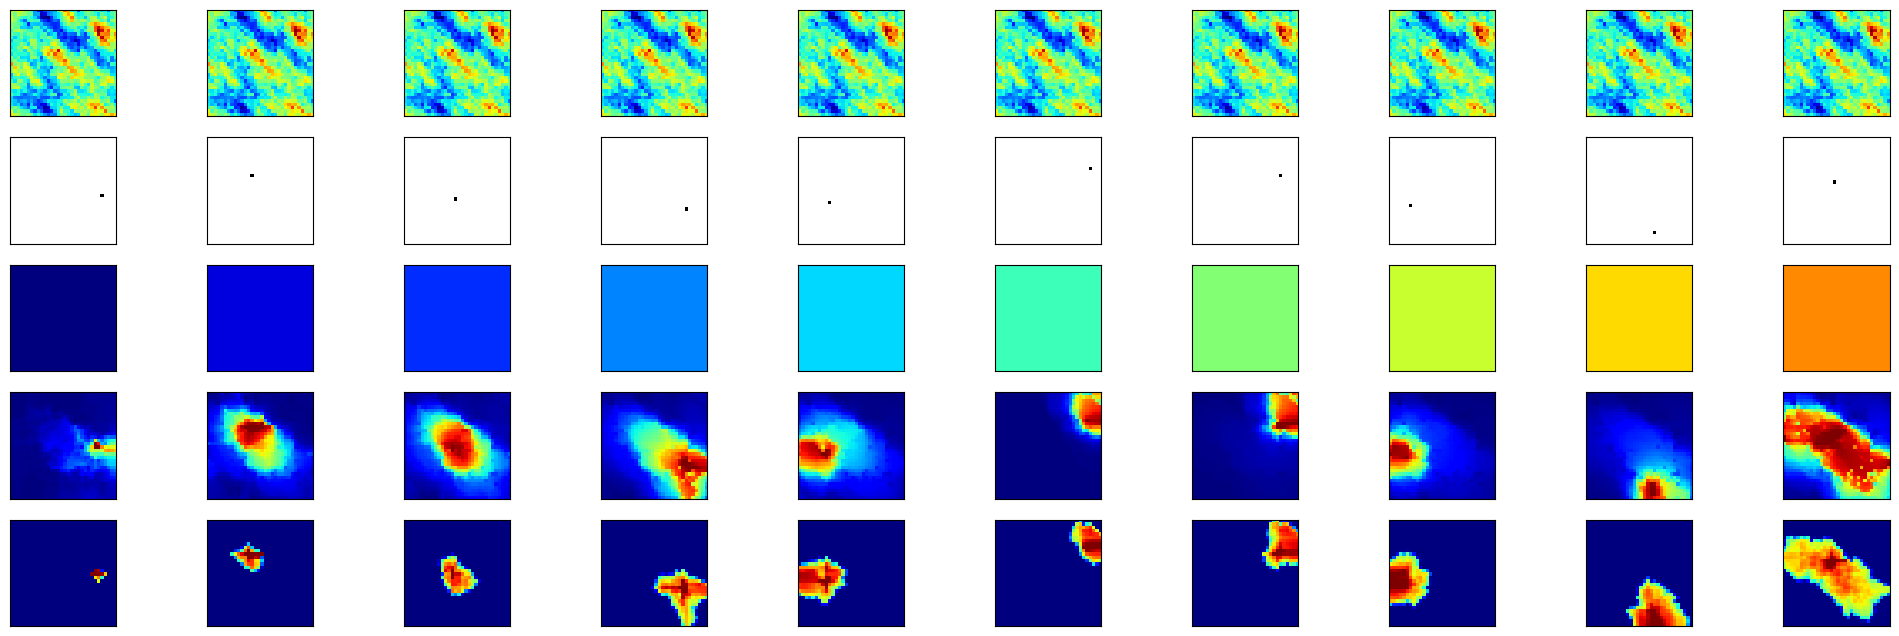

In [179]:
cmaps = ['jet','binary','jet']
k = 125
fig, axs = plt.subplots(5, 10, figsize=(25,8))
for j in range(10):
    for i in range(3):
        if i == 2:
            axs[i,j].imshow(x_data[j*k,:,:,i], cmap=cmaps[i], vmin=0, vmax=1)
        else:
            axs[i,j].imshow(x_data[j*k,:,:,i], cmap=cmaps[i])
        axs[i,j].set(xticks=[], yticks=[])
    for i in range(3,5):
        axs[i,j].imshow(y_data[j*k,:,:,i-3], 'jet')
        axs[i,j].set(xticks=[], yticks=[])

In [180]:
def make_cnn():
    keras.backend.clear_session()
    inp = Input(shape=(32, 32, 3))
    
    x = Conv2D(filters=16, kernel_size=3, padding='same', activation=LeakyReLU())(inp)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(filters=32, kernel_size=3, padding='same', activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(filters=64, kernel_size=3, padding='same', activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(filters=32, kernel_size=3, padding='same', activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = UpSampling2D()(x)

    x = Conv2D(filters=16, kernel_size=3, padding='same', activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = UpSampling2D()(x)
    
    x = Conv2D(filters=16, kernel_size=3, padding='same', activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = UpSampling2D()(x)
    
    out = Conv2D(filters=2, kernel_size=3, padding='same')(x)
    return Model(inp, out)

proxy = make_cnn()
#proxy.summary()

proxy.compile(optimizer='adam', loss='mse', metrics=['mse'])
fit = proxy.fit(x_data, y_data,
                epochs = 100,
                batch_size = 60,
                validation_split = 0.2,
                verbose = 0)

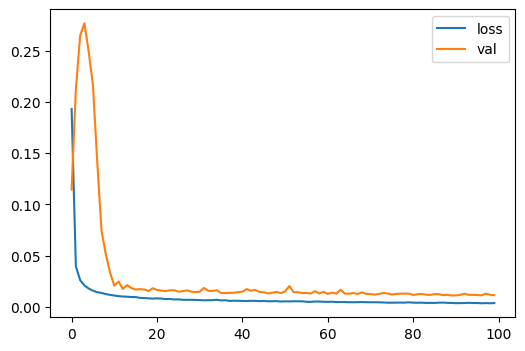

In [181]:
plt.figure(figsize=(6,4))
plt.plot(fit.history['loss'], label='loss')
plt.plot(fit.history['val_loss'], label='val')
plt.legend(); plt.show()

In [182]:
y_data_pred = proxy.predict(x_data)
print('y_pred: {}'.format(y_data_pred.shape))

188/188 [==============================] - 1s 2ms/step
y_pred: (6000, 32, 32, 2)


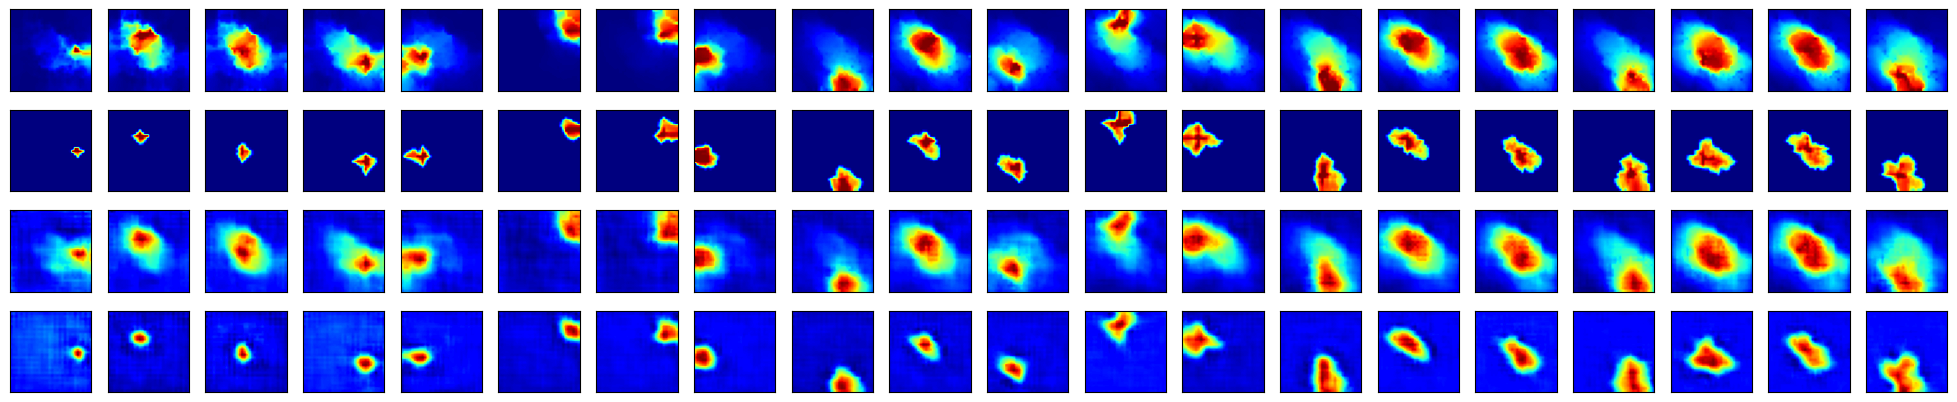

In [183]:
k = 121
fig, axs = plt.subplots(4, 20, figsize=(25,5))
for j in range(20):
    for i in range(2):
        axs[i,j].imshow(y_data[j*k,:,:,i], 'jet')
        axs[i,j].set(xticks=[], yticks=[])
    for i in range(2,4):
        axs[i,j].imshow(y_data_pred[j*k,:,:,i-2], 'jet')
        axs[i,j].set(xticks=[], yticks=[])

In [234]:
temp = np.zeros((6000,32,32,1))
temp[:, 20, 21] = 1
temp[:, 5, 9] = 1

newp = np.expand_dims(x_data[...,0],-1)
neww = temp
newt = np.expand_dims(x_data[...,2], -1)
print(newp.shape, neww.shape, newt.shape)

newx = np.expand_dims(np.concatenate([newp, neww, newt], -1)[0],0)
print(newx.shape)

newy = proxy.predict(newx)
print(newy.shape)

(6000, 32, 32, 1) (6000, 32, 32, 1) (6000, 32, 32, 1)
(1, 32, 32, 3)
1/1 [==============================] - 0s 20ms/step
(1, 32, 32, 2)


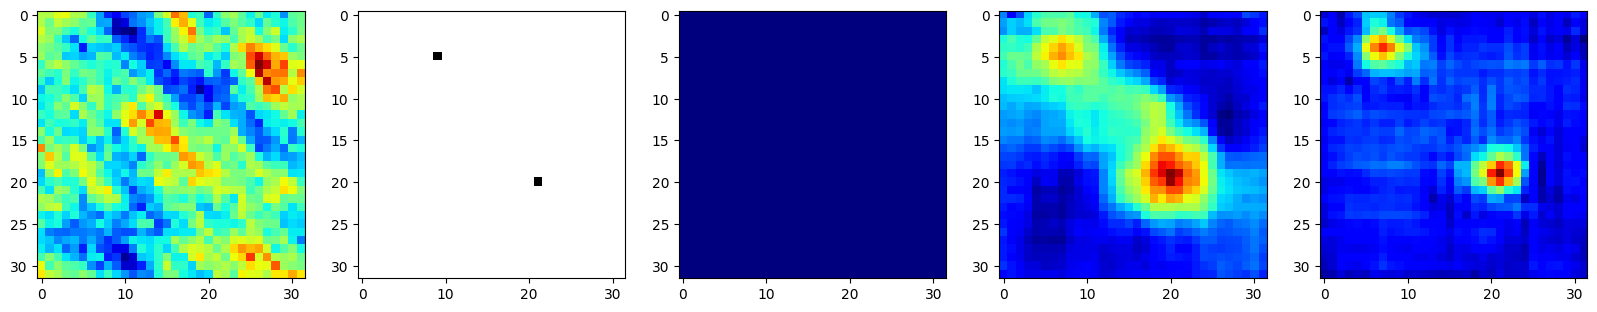

In [235]:
fig, axs = plt.subplots(1,5, figsize=(20,4))
for i in range(3):
    axs[i].imshow(newx.squeeze()[:,:,i], cmap=cmaps[i], vmin=0, vmax=1)
for i in range(3,5):
    axs[i].imshow(newy.squeeze()[:,:,i-3], 'jet')

***
# 3D

In [8]:
poro = np.moveaxis(loadmat('simulations/poro.mat')['poro'].reshape(50,5,32,32).T, -1,0)
logpermx = np.log10(np.moveaxis(loadmat('simulations/perm.mat')['perm'][...,0].reshape(50,5,32,32).T, -1, 0))
logpermy = np.log10(np.moveaxis(loadmat('simulations/perm.mat')['perm'][...,1].reshape(50,5,32,32).T, -1, 0))
logpermz = np.log10(np.moveaxis(loadmat('simulations/perm.mat')['perm'][...,2].reshape(50,5,32,32).T, -1, 0))

saturation = np.moveaxis(loadmat('simulations/saturation.mat')['saturation'].reshape(50,75,5,32,32), 2, -1)
pressure   = np.moveaxis(loadmat('simulations/pressure.mat')['pressure'].reshape(50,75,5,32,32), 2, -1)

inj_loc = loadmat('simulations/inj_loc.mat')['inj_loc']
injloc = np.zeros((50,32,32,5))
for i in range(50):
    injloc[i, inj_loc[i][1]-1, inj_loc[i][0]-1, :] = 1    

mon_loc_data = loadmat('simulations/mon_locations.mat')['mon_locations']
mon_loc, monloc = {}, np.zeros((50,32,32,5))
for i in range(50):
    mon_loc[i] = mon_loc_data[i][0]-1
    monloc[i, mon_loc[i][:,1], mon_loc[i][:,0], :] = 1

FileNotFoundError: [Errno 2] No such file or directory: 'simulations/pressure.mat'

In [ ]:
k = 36
t = 70
plt.figure(figsize=(30,5))
plt.suptitle('Saturation')
for i in range(5):
    plt.subplot(1,5,i+1)
    im=plt.imshow(saturation[k,t,:,:,i], cmap='jet', vmin=0, vmax=1)
    plt.scatter(inj_loc[k][0], inj_loc[k][1], c='k', marker='d', s=60, label='Injector')
    plt.title('# {} - Inj={} - Layer {} - Time {}'.format(k, inj_loc[k], i, t))
    plt.colorbar(im,fraction=0.046, pad=0.04)
    for j in range(len(mon_loc[k])):
        plt.scatter(mon_loc[k][:,0], mon_loc[k][:,1], c='red', marker='*', s=50, label='Monitor {}'.format(j+1))
    plt.legend(bbox_to_anchor=(1.05, -0.05), fancybox=True, shadow=True, ncol=3)
plt.show()

plt.figure(figsize=(30,5))
plt.suptitle('Pressure')
for i in range(5):
    plt.subplot(1,5,i+1)
    im=plt.imshow(pressure[k,t,:,:,i], cmap='turbo')
    plt.scatter(inj_loc[k][0], inj_loc[k][1], c='k', marker='d', s=60, label='Injector')
    plt.title('# {} - Inj={} - Layer {} - Time {}'.format(k, inj_loc[k], i, t))
    plt.colorbar(im,fraction=0.046, pad=0.04)
    for j in range(len(mon_loc[k])):
        plt.scatter(mon_loc[k][:,0], mon_loc[k][:,1], c='red', marker='*', s=50, label='Monitor {}'.format(j+1))
    plt.legend(bbox_to_anchor=(1.05, -0.05), fancybox=True, shadow=True, ncol=3)
plt.show()

***

In [ ]:
X_data  = np.concatenate([np.expand_dims(poro,-1), np.expand_dims(logpermx,-1), np.expand_dims(logpermz,-1), np.expand_dims(injloc,-1), np.expand_dims(monloc,-1)], -1)
x_train = X_data[:40]
x_test  = X_data[40:]
print('X --> train:', x_train.shape, '| test:', x_test.shape)

y_data  = np.concatenate([np.expand_dims(pressure,-1), np.expand_dims(saturation,-1)], -1)
y_train = y_data[:40]
y_test  = y_data[40:]
print('Y --> train:', y_train.shape, '| test:', y_test.shape)